## Auto mode

This is for testing propouses

In [1]:
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt

from config import DATA_PATH, Color
from helpers import clean  #, local2global
from helpers.change_coordinates import GRA, GRAs_to_ENUs
from mavlink.customtypes.location import ENUPose, GRAPose
from plan import Plan
from simulator import (
    QGC,
    ConfigGazebo,
    ConfigNovis,
    ConfigQGC,
    Gazebo,
    NoVisualizer,
    Simulator,
)

clean()

## Simulation Configuration

In [2]:
gra_origin = GRAPose(lat=-35.3633280, lon=149.1652241,alt=0,heading=90) 
enu_origin = ENUPose(x=0, y=0, z=gra_origin.alt, heading=gra_origin.heading) 

base_homes= ENUPose.list([  # east, north, up, heading
    (0., 15., 0., 30.),
    (15., 0., 0., 0),
    (-15., -15., 0., 0),
    (-15., 0., 0., 45),
    (5., -20., 0., 0.),
])
base_paths = [Plan.create_square_path(side_len=10, alt=5,heading=0) for _ in base_homes]

gcs_colors=[
    Color.BLUE,
    Color.BLUE,
    Color.BLUE,
    Color.RED,
    Color.RED,
]


## Assign vehicles to GCS (by color)
gcs_sysids: dict[str, list[int]] = defaultdict(list)

for i,color in enumerate(gcs_colors,start=1):
    gcs_sysids[f'{color.name} {color.emoji}'].append(i)

## Gazebo Congiguration

In [3]:
gaz_config = ConfigGazebo(origin = enu_origin,
                          world_path="simulator/gazebo/worlds/runway.world")

for path,home,c in zip(base_paths,base_homes,gcs_colors):
    gaz_config.add(base_path=path,base_home=home,color=c)
gaz_config.show()

## QGroundControl Configuration

In [4]:
qgc_config = ConfigQGC(origin = gra_origin)

for path,home,color in zip(base_paths,base_homes,gcs_colors):
    qgc_config.add(base_path=path,base_home=home,color=color)
qgc_config.show()

# No Simulator

In [5]:
novis_config = ConfigNovis(origin=gra_origin)
for home in base_homes:
    novis_config.add(base_home=home)

## Visualizers

In [6]:
novis=NoVisualizer(novis_config)

gaz= Gazebo(gaz_config,gra_origin)

qgc=QGC(qgc_config)

## Launch Simulatotion

In [7]:
simulator = Simulator(
	visualizers=[qgc],
	gcs_sysids=gcs_sysids,
	missions=[veh.mission for veh in qgc_config.vehicles],
	terminals=['gcs'],
	verbose=2,
)

orac = simulator.launch()

🚀 GCS BLUE 🟦 launched (PID 348425)
🚀 GCS RED 🟥 launched (PID 348426)
🔗 UAV logic 3 is connected to Oracle ⚪
🔗 UAV logic 2 is connected to Oracle ⚪
🔗 UAV logic 5 is connected to Oracle ⚪
🔗 UAV logic 1 is connected to Oracle ⚪
🔗 UAV logic 4 is connected to Oracle ⚪
🗺️ QGroundControl launched for 2D visualization — simulation powered by ArduPilot SITL.


## Oracle checking

In [8]:
orac.run()

Oracle ⚪: 🏁 Starting Oracle with 5 vehicles
Oracle ⚪: 🔁 Received Remote ID from 5
Oracle ⚪: 🔁 Received Remote ID from 1
Oracle ⚪: 🔁 Received Remote ID from 4
Oracle ⚪: 🔁 Received Remote ID from 3
Oracle ⚪: 🔁 Received Remote ID from 2
Oracle ⚪: 🔁 Received Remote ID from 5
Oracle ⚪: 🔁 Received Remote ID from 1
Oracle ⚪: 🔁 Received Remote ID from 4
Vehicle 5: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 2: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 1: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 5: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 2: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 1: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 3: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 4: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 5: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 2: 📍 Position: lat=0.0000000, lon=0.0000000, alt=0.00 m
Vehicle 1: 📍

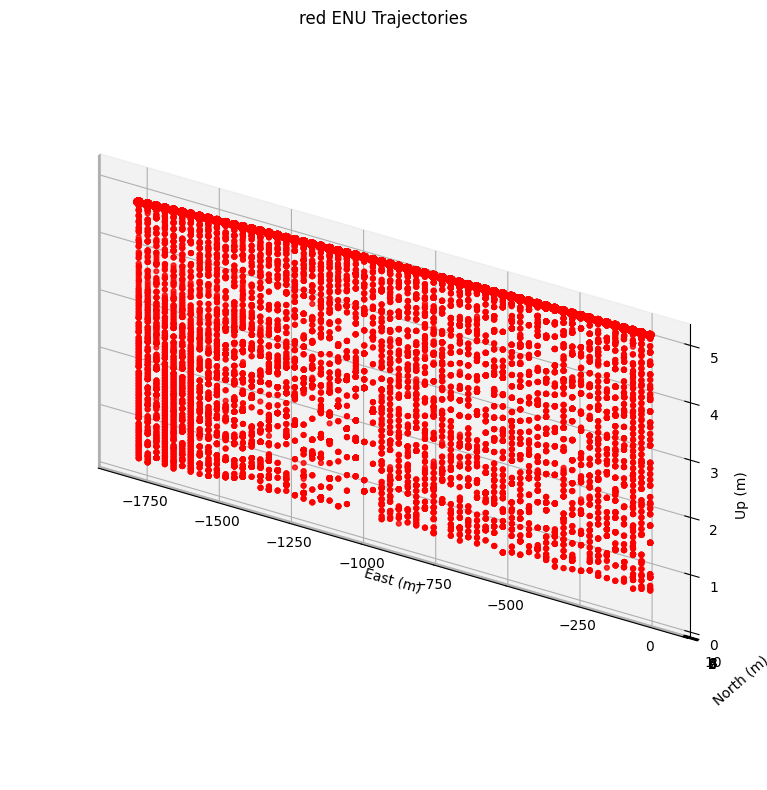

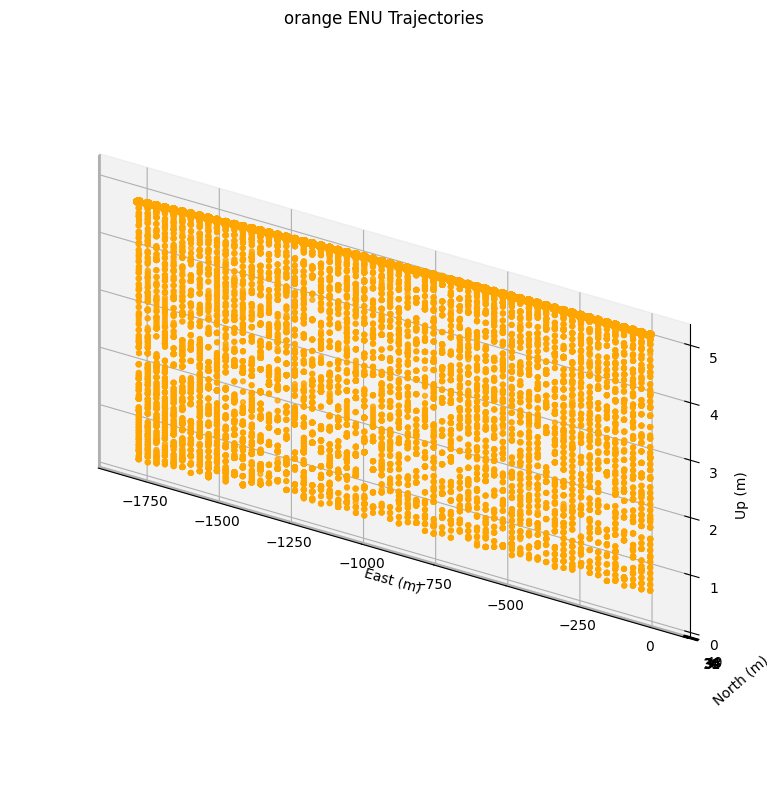

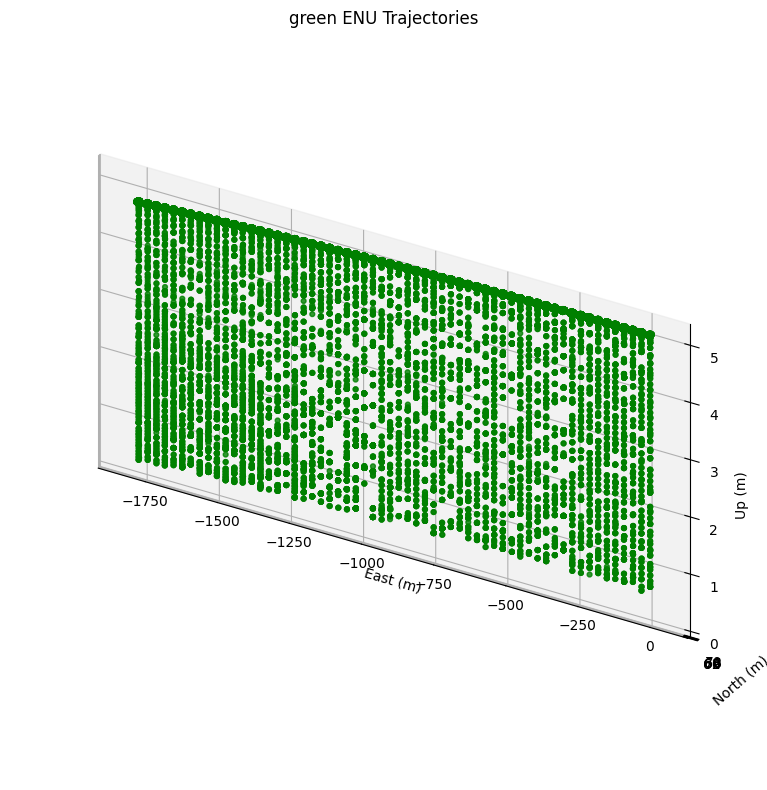

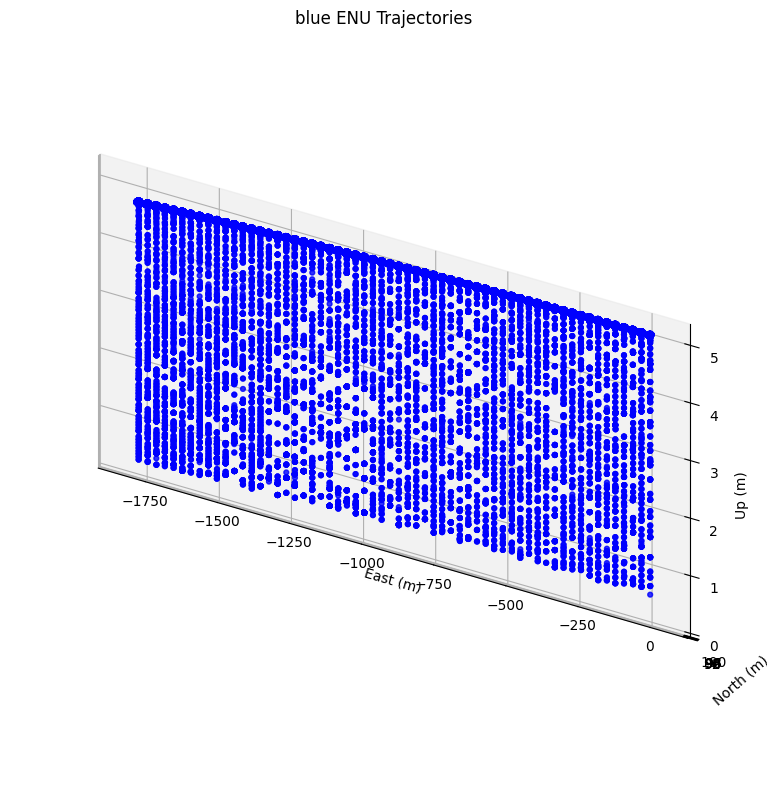

In [ ]:
unique_colors = list(dict.fromkeys(gcs_colors))
n_uavs_per_gcs = 60
unique_colors = [Color.RED,
     Color.ORANGE,
     Color.GREEN,
     Color.BLUE]
gcs_sysids = [
    list(range(i * n_uavs_per_gcs + 1, (i + 1) * n_uavs_per_gcs + 1)) 
    for i in range(len(unique_colors))
    ]
for color in unique_colors:
    # Load raw GRA paths
    filepath = DATA_PATH / f"trajectories_{color.name} {color.emoji}.pkl"
    with open(filepath, "rb") as f:
        trajs = pickle.load(f)  # dict: sysid -> list of GRA

    # GCS figure
    fig = plt.figure(figsize=(8, 8))# type: ignore
    ax = fig.add_subplot(projection="3d", proj_type="ortho")# type: ignore
    ax.set_title(f"{color} ENU Trajectories")# type: ignore
    ax.set_xlabel("East (m)")# type: ignore
    ax.set_ylabel("North (m)")# type: ignore
    ax.set_zlabel("Up (m)")# type: ignore

    for sysid, gra_path in trajs.items():
        # Filter trajectories and convert to ENU
        gra_valid = [p for p in gra_path if abs(p.alt) > 0.5]
        enu = GRAs_to_ENUs(GRA(*gra_origin[:3]), gra_valid)

        # Plot Trajectory
        xs = [p.x for p in enu]
        ys = [p.y for p in enu]
        zs = [p.z for p in enu]
        ax.scatter(xs, ys, zs, # type: ignore
                   c=[color.value], s=12, alpha=0.8, # type: ignore
                   label=f"UAV {sysid}", depthshade=True)

    ax.set_aspect(aspect='equalxy') # type: ignore
    plt.tight_layout()
    plt.show() # type: ignore


